# Análisis de datos de IM por medio de la matriz de grado

In [1]:
import numpy as np
import pandas as pd 
import networkx as nx
import math
import sympy as sp
import matplotlib.pyplot as plt

from sympy import *
from numpy import linalg as LA
from numpy.linalg import matrix_rank

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"

In [3]:
#Establecer directorio de datos

DIR='/Users/alex/Desktop/MatrizAdjSano/MatrizAdjSano'
FILE='/adjmatrix_UNS.txt'

file='{}{}'.format(DIR,FILE)

print('File directory:{}'.format(file))

File directory:/Users/alex/Desktop/MatrizAdjSano/MatrizAdjSano/adjmatrix_UNS.txt


In [ ]:
data=pd.read_table(file)

In [6]:
data.head()

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
0,1.0,0.103197,0.152306,0.107439,0.151863,0.050207,0.047916,0.152306,0.162813,0.032128,...,0.038779,0.016197,0.052990,0.062391,0.070298,0.038779,0.044215,0.259474,0.151107,0.074188
1,NaN,1.000000,0.120830,0.128810,0.121863,0.076382,0.064962,0.120830,0.250164,0.102605,...,0.108833,0.124237,0.120423,0.125844,0.020272,0.108833,0.127723,0.069236,0.199134,0.112418
2,NaN,NaN,1.000000,0.051569,0.107554,0.057486,0.038834,0.334130,0.248721,0.048574,...,0.059112,0.044184,0.051950,0.091854,0.071886,0.059112,0.030633,0.097257,0.045373,0.075525
3,NaN,NaN,NaN,1.000000,0.032182,0.069682,0.042741,0.051569,0.126349,0.051244,...,0.054916,0.133838,0.062266,0.132682,0.021764,0.054916,0.103477,0.123546,0.184396,0.057522
4,NaN,NaN,NaN,NaN,1.000000,0.214658,0.029944,0.107554,0.108194,0.094873,...,0.102947,0.156264,0.069491,0.128388,0.018218,0.102947,0.094818,0.178692,0.051804,0.064486


In [7]:
a=np.diag(np.ones(16748),0)
A=data-a

In [8]:
#Este modulo calcula un valor umbral ("threshold") que promedia todos los valores de las 
# entradas de un data set

# Función convertir a lista el resultado de aplicar .mean() a un DataFrame

def mean_to_list(df):
    arr=[]
    for i in range(0,len(df)):
        a=df.iloc[i]
        arr.append(a)
    return arr

# Función para calcular el promedio de las entradas de una lista 

def cal_prom_en_list(num):
    sum_num=0
    for entrada in num:
        sum_num=sum_num +entrada
        
    prom = sum_num/len(num)
    return prom

# Cálculo del umbral, promediando sobre todas las entradas de la matriz de adyacencia

A_prom_cols=A.mean()
A_mean_list=mean_to_list(A_prom_cols)
cal_prom_en_list(A_mean_list)
threshold=cal_prom_en_list(A_mean_list)

0.08567775225309081

In [9]:
#Función para contruir la matriz de grado a partir de la de la matriz de adyacencia

def degreeMat_from_Adj(mat,n):
    new_data=mat.iloc[:n,:n]
    
    new_data2=new_data.apply(lambda x:(np.where(x<threshold,0,x)))
    adj_mat=new_data2.apply(lambda x:(np.where(x>threshold,1,x)))
    
    #completar la matriz triangular superior para tener la forma completa de una matriz
    # simétrica
    
    adj_mod=np.matrix(adj_mat.fillna(0))
    adj_mod_trans=adj_mod.transpose()
    simm_mat=adj_mod+adj_mod_trans    #type(simm_mat)=numpy matrix
    
    
    Adj_to_nx=nx.from_numpy_matrix(simm_mat)
    L_from_Adj=nx.laplacian_matrix(Adj_to_nx) #obtener la Laplaciana asociada a la de adyacencia
    
    L_arr=L_from_Adj.toarray()
    
    L_np=np.matrix(L_arr)
    
    deg_Mat=L_np+simm_mat
    
    return deg_Mat

In [14]:
# El siguiente módulo, crea un array con los primeros "n" genes que deseen obtener del
# Data Frame "data"

#Parametros: data , n 

def get_genes(data,n):
    
    genes_arr = sorted(data) #obtener un array que contiene los elementos del header del DataFrame
    num_genes_extracted = range(n)
    genes = np.array(genes_arr)[num_genes_extracted]
    
    return genes

In [15]:
#Este script es capaz de dibujar el grafo con sus vértices respectivos etiquetados

#Este módulo ha sifo modificado para que sea capaz de etiquetar los nombres de los genes 
#involucrados

def plt_with_label(mat,n):
    
    new_data=mat.iloc[:n,:n]
    
    new_data2=new_data.apply(lambda x:(np.where(x<threshold,0,x)))
    adj_mat=new_data2.apply(lambda x:(np.where(x>threshold,1,x)))
    
    #completar la matriz triangular superior para tener la forma completa de una matriz
    # simétrica
    
    adj_mod=np.matrix(adj_mat.fillna(0))
    adj_mod_trans=adj_mod.transpose()
    simm_mat=adj_mod+adj_mod_trans
    adj_to_graph=nx.from_numpy_matrix(simm_mat)
    
    labelmap=dict(zip(adj_to_graph.nodes(),get_genes(data,n))) # el primer parámetro es 
    #el grupo de nodos que será manipulado y el segundo todos los nombres o etiquetas que se usaran
    
    plt.figure(1,figsize=(12,12))
    nx.draw(adj_to_graph, labels=labelmap, with_labels=True,
    font_size=7,font_weight='bold',font_color='green',edge_color='gray',node_color='blue')
    
    
    
    graph_with_lab=plt.show()
    
    return graph_with_lab

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


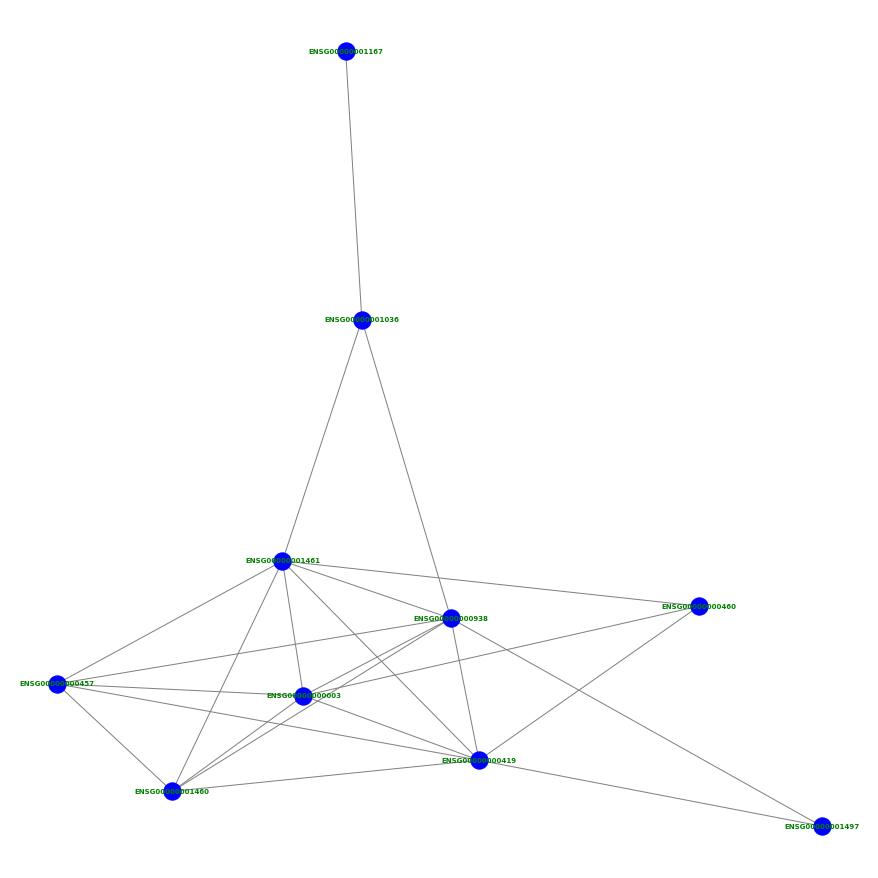

In [21]:
plt_with_label(A,10)

In [23]:
Mat_p=degreeMat_from_Adj(A,4)

In [3]:
#La siguiente función sirve para obtener los elementos de la diagonal de la matriz de
# grado y la guarda en un array llamado out_p


def get_elem_in_diag(Mat):
    Mat_mod = np.squeeze(np.asarray(Mat))#convierte numpy matrix en array
    out_p=[]
    for elem in np.nditer(Mat_mod): #nditer itera sobre arrays
        if elem != 0: # omite los valores 0 en el array pues la matriz de grado fuera de la diagonal tiene solo ceros
            out_p.append(int(elem))
            
    return out_p 
    

In [2]:
#Función para obtener el número mayor de una lista de números dentro de un array

# El parámetro debe tener el mismo número que la dimensión de la matriz 
# de grado que se está analizando

def get_biggest_num_in_diag(l,n):
    count=0
    for i in range(n):
        for j in range(n):
            if l[j]>l[i]:
                count=l[j]
    return count   

# En la siguiente función el parámetro "a" es un array que contiene los elementos de 
# la diagonal de la matriz de grado y "N" es el número de elementos que se tomará para
# ordenarlos de mayor a menor.

# El output indica la posición de la entrada y no su valor, pues con ello podremos 
# identificar cuál es el gen que tiene más aristas incidentes dentro de él 

def func(a,N):
    return np.argsort(a)[::-1][:N]

In [4]:
func(get_elem_in_diag(degreeMat_from_Adj(A,100)),100)

NameError: name 'degreeMat_from_Adj' is not defined